In [1]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" "https://storage.googleapis.com/kaggle-competitions-data/kaggle/3539/Train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1544846900&Signature=VpvEoiAPLVQADJmDGkr5vmEve70CtT57%2B8rR19Dab5s%2FmACny96iDHIl2xuwuijuY7cSTJXScnCIOgvFbr8hjdMM3O0YfOQUPtm2GvdiFSMVVeCGU4Dl%2Fkd2gPBYnhpyPH%2BJ9valn%2FHTHheDq0k%2Bb1fMZrAEbdpNx7w2QTTKibEMQ9w75VM1kOOG8J40XYDw5P1r9gDlECQarflGzgCF4J9LuWUOzks56fqKdShnIKAZXH4ZFRCap%2FsV4T1Du6HqfXgYsLrOwzwA7Vsa6Ebls2dQqKR%2FJDNfH5vkJFq7PCCeOMXCQH0HeIa6wqdkdfvsz3FteZOn7%2B0vZBvlbnyuRA%3D%3D" -O "Train.zip" -c

--2018-12-12 04:09:18--  https://storage.googleapis.com/kaggle-competitions-data/kaggle/3539/Train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1544846900&Signature=VpvEoiAPLVQADJmDGkr5vmEve70CtT57%2B8rR19Dab5s%2FmACny96iDHIl2xuwuijuY7cSTJXScnCIOgvFbr8hjdMM3O0YfOQUPtm2GvdiFSMVVeCGU4Dl%2Fkd2gPBYnhpyPH%2BJ9valn%2FHTHheDq0k%2Bb1fMZrAEbdpNx7w2QTTKibEMQ9w75VM1kOOG8J40XYDw5P1r9gDlECQarflGzgCF4J9LuWUOzks56fqKdShnIKAZXH4ZFRCap%2FsV4T1Du6HqfXgYsLrOwzwA7Vsa6Ebls2dQqKR%2FJDNfH5vkJFq7PCCeOMXCQH0HeIa6wqdkdfvsz3FteZOn7%2B0vZBvlbnyuRA%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.8.16, 2607:f8b0:4004:803::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.8.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2347110159 (2.2G) [application/zip]
Saving to: 'Train.zip'

Train.zip           100%[===================>]   2.19G  64.7MB/s    in 50s     

2018-12-12 04:10:08 (44.7 MB/s) - 'Train.zip' sav

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

!pip3 install wordcloud
from wordcloud import WordCloud
import re
import os

!pip3 install sqlalchemy
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

!pip3 install scikit-multilearn
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Question Tag Prediction: Tag Prediction

## 1. Business Problem

### 1.1 Description

#### Description
Question Tag Prediction is a Business problem related to students mailing system. Students post various questions related to several departments like sales, administration, technical etc. Objective is to predict the Tag for the students post and assigning the tag directly to related department. By which we can achieve the delay in response and also saving the resources.

#### Problem Statemtent

Suggest the tags based on the content that was there in the question posted.

## 1.3 Real World / Business Objectives and Constraints ¶

#### Predict as many tags as possible with high precision and recall.
#### Incorrect tags could impact customer experience.
#### No strict latency constraints.

### 2. Machine Learning problem 

### 2.1.1 Data Overview 
Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data 
All of the data is in 2 files: Train and Test.

Train.csv contains 4 columns: Id,Title,Body,Tags.

Test.csv contains the same columns but without the Tags, which you are to predict.

Size of Train.csv - 6.75GB

Size of Test.csv - 2GB

Number of rows in Train.csv = 6034195

The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).

Data Field Explaination

Dataset contains 6,034,195 rows. The columns in the table are:

Id - Unique identifier for each question

Title - The question's title

Body - The body of the question

Tags - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')


### 2.2 Mapping the real-world problem to a Machine Learning Problem 

#### 2.2.1 Type of Machine Learning Problem

It is a multi-label classification problem 
Multi-label Classification: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on MailChainSystem might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. 
Credit: http://scikit-learn.org/stable/modules/multiclass.html

#### 2.2.2 Performance metric 

Micro-Averaged F1-Score (Mean F Score) : The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 (precision recall) / (precision + recall)

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. 

'Micro f1 score': 
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance. 

'Macro f1 score': 
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account. 

https://www.kaggle.com/wiki/MeanFScore 
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html 

Hamming loss : The Hamming loss is the fraction of labels that are incorrectly predicted. 
https://www.kaggle.com/wiki/HammingLoss 

## 3. Exploratory Data Analysis 

#### 3.1 Data Loading and Cleaning

In [ ]:
import zipfile
with zipfile.ZipFile('/resources/Train.zip', 'r') as zip_ref:
    zip_ref.extractall('/resources/unzippedTrain')

In [27]:
df = pd.read_csv("unzippedTrain/Train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 6034195


In [19]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

#sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
#create_database_table("Processed.db", sql_create_table)

In [7]:
!wget --header="Host: doc-0s-10-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.110 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_tir2eb2jr3rovrte1044a2fgdv0mg3vu_nonce=penb5241tjihk" --header="Connection: keep-alive" "https://doc-0s-10-docs.googleusercontent.com/docs/securesc/d3m0kshppgn8tksv4meb538doens50h4/u1mphgoqpfv0q8h8ghdbgvmqcqtqlctu/1544601600000/06629147635963609455/18316446316963573968/18tA34r3269sybix_jsrDPnWchaaHXpF7?e=download&nonce=penb5241tjihk&user=18316446316963573968&hash=aen8r4f2e9fgsm2h72j4dvt147civvef" -O "train_no_dup.db" -c

--2018-12-12 08:29:46--  https://doc-0s-10-docs.googleusercontent.com/docs/securesc/d3m0kshppgn8tksv4meb538doens50h4/u1mphgoqpfv0q8h8ghdbgvmqcqtqlctu/1544601600000/06629147635963609455/18316446316963573968/18tA34r3269sybix_jsrDPnWchaaHXpF7?e=download&nonce=penb5241tjihk&user=18316446316963573968&hash=aen8r4f2e9fgsm2h72j4dvt147civvef
Resolving doc-0s-10-docs.googleusercontent.com (doc-0s-10-docs.googleusercontent.com)... 172.217.5.225, 2607:f8b0:4004:805::2001
Connecting to doc-0s-10-docs.googleusercontent.com (doc-0s-10-docs.googleusercontent.com)|172.217.5.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: 'train_no_dup.db'

train_no_dup.db         [   <=>              ]   5.74G  95.7MB/s    in 65s     

2018-12-12 08:30:51 (90.9 MB/s) - 'train_no_dup.db' saved [6164336640]



In [8]:
import os
#Taking 0.5 Million entries to a dataframe.
write_db = r'train_no_dup.db'
if os.path.isfile(write_db):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:00:12.378116


### 3.2 Analysis of Tags 

#### 3.2.1 Total number of unique tags 

In [10]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [11]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [12]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


### 3.2.3 Number of times a tag appeared

In [ ]:
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [15]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [16]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

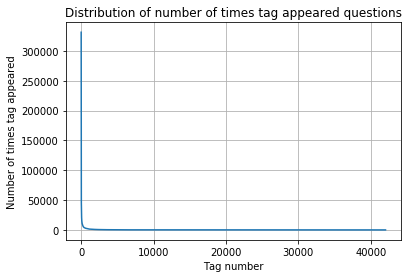

In [17]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

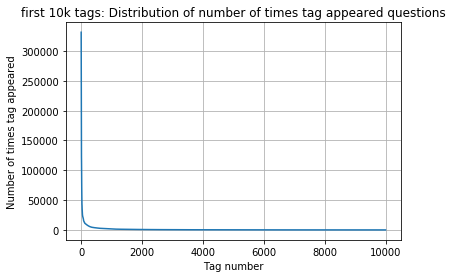

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2989   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [18]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

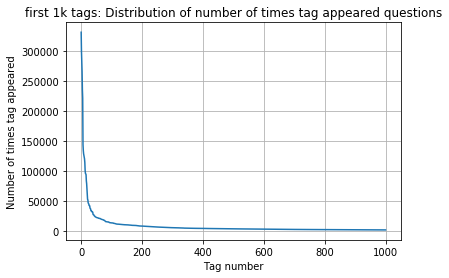

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2989   2984   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [19]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

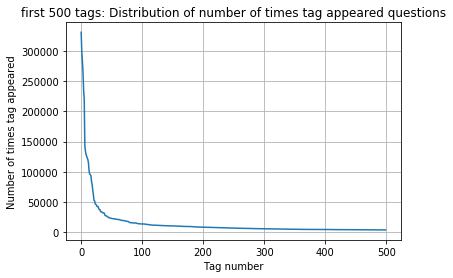

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [20]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

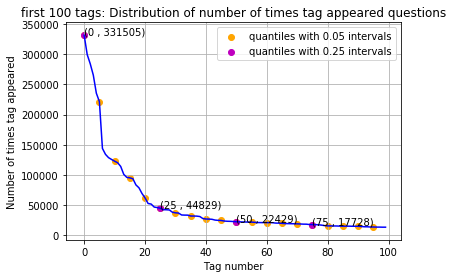

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [21]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [22]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


### Observations:

1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

#### 3.2.4 Tags Per Question 

In [24]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [25]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.899440


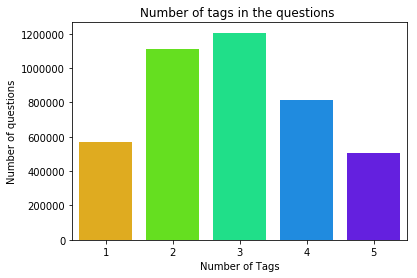

In [26]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

#### Observations:

1.  Maximum number of tags per question: 5
2.  Minimum number of tags per question: 1
3.  Avg. number of tags per question: 2.899
4.  Most of the questions are having 2 or 3 tags

### 3.2.5 Most Frequent Tags 

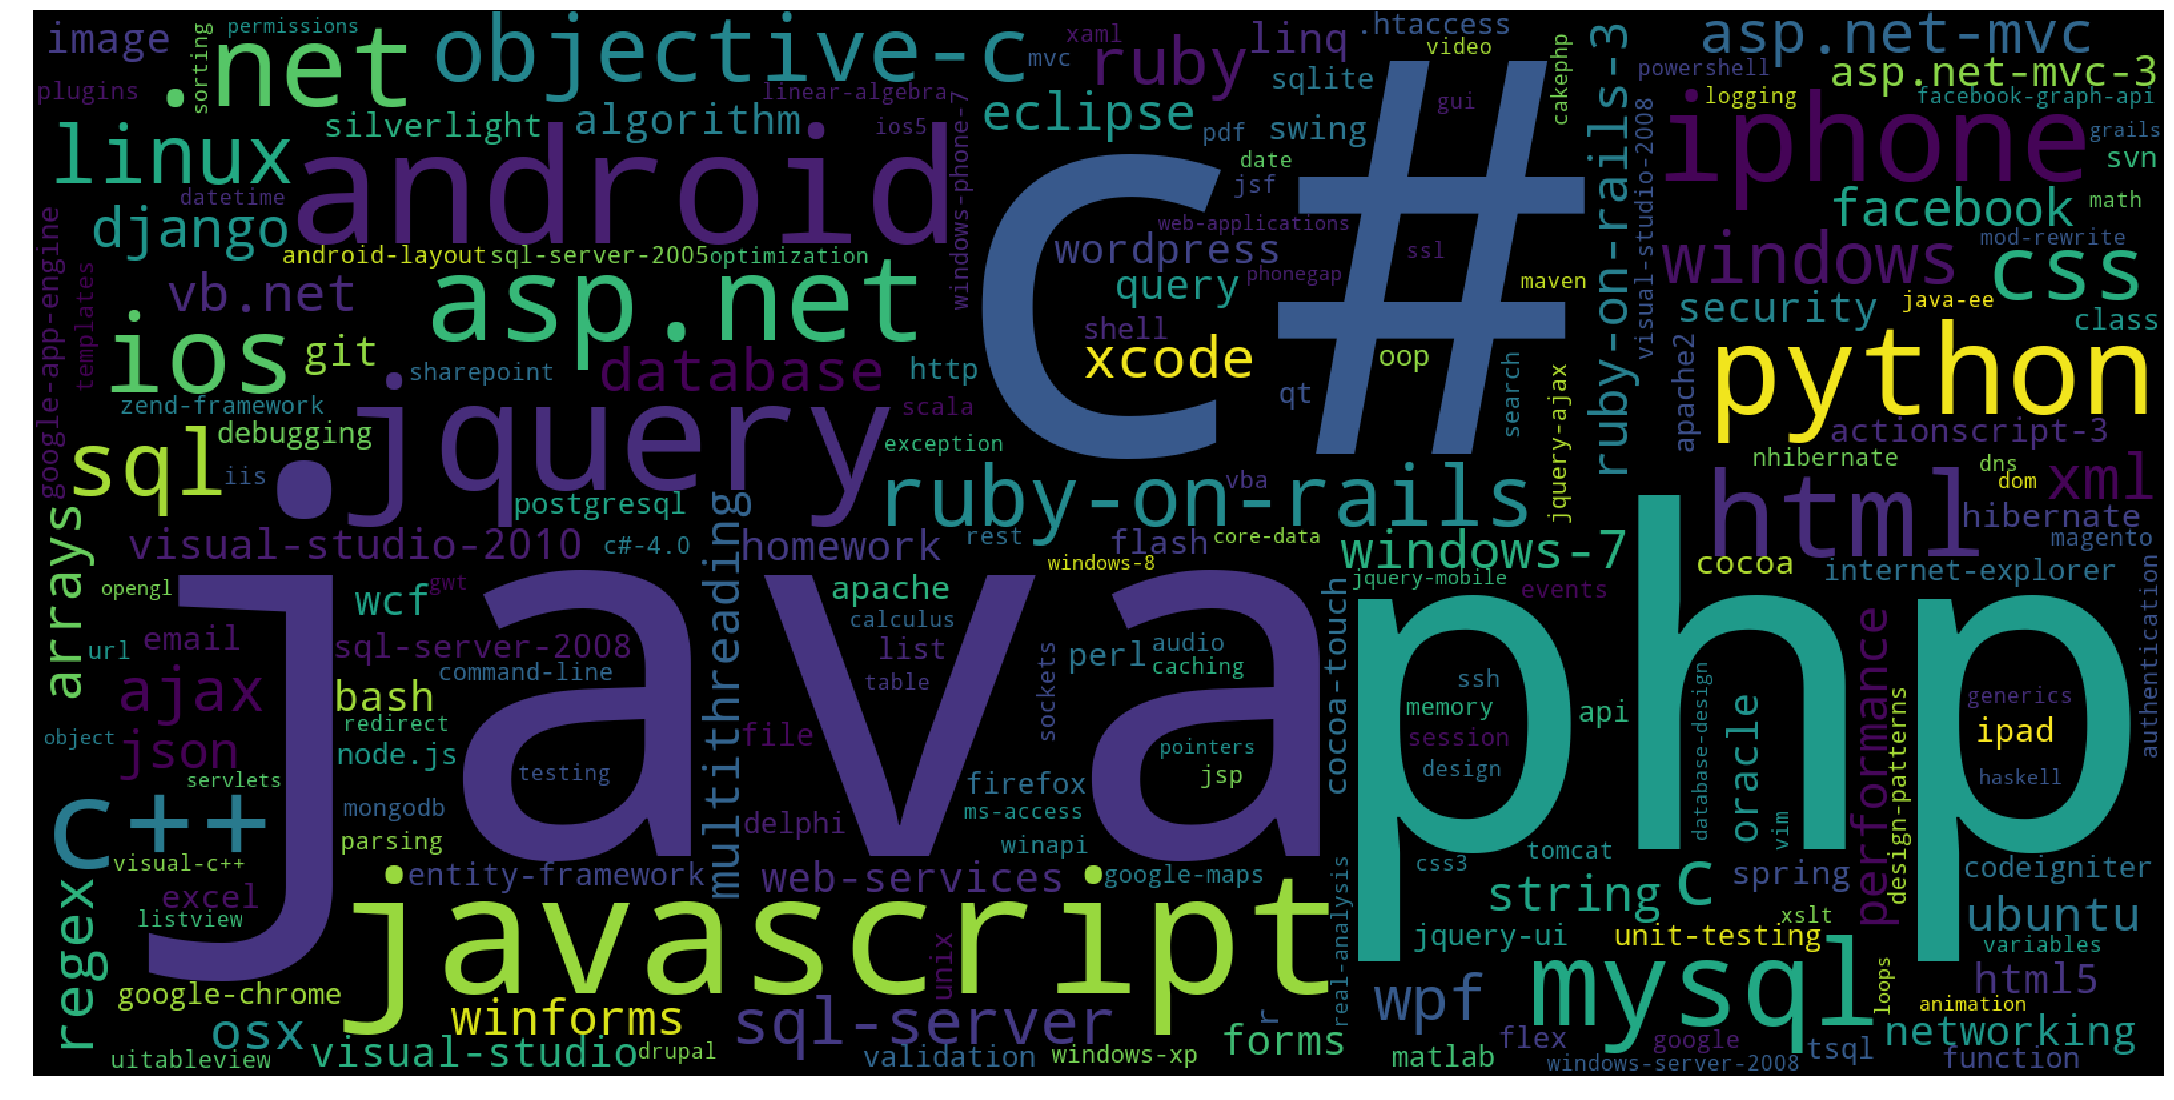

Time taken to run this cell : 0:00:13.752664


In [27]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

#### Observations:
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

### 3.2.6 The top 20 tags

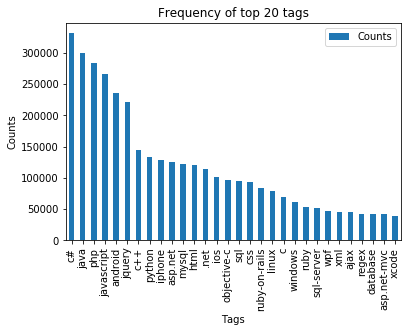

In [28]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

#### Observations:

1.  Majority of the most frequent tags are programming language.
2.  C# is the top most frequent programming language.
3.  Android, IOS, Linux and windows are among the top most frequent operating systems.

### 3.3 Cleaning and preprocessing of Questions

#### 3.3.1 Preprocessing 
    Sample 1M data points
    Separate out code-snippets from Body
    Remove Spcial characters from Question title and description (not in code)
    Remove stop words (Except 'C')
    Remove HTML Tags
    Convert all the characters into small letters
    Use SnowballStemmer to stem the words

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [31]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [3]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [33]:
# http://www.sqlitetutorial.net/sqlite-delete/

start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

Tables in the databse:
QuestionsProcessed
Cleared All the rows
Time taken to run this cell : 0:03:37.999569


#### we create a new data base to store the sampled and preprocessed questions

In [35]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:

    is_code = 0

    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1172
Avg. length of questions(Title+Body) after processing: 326
Percent of questions containing code: 57
Time taken to run this cell : 0:59:16.502405


In [37]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [38]:

if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('sharepoint display extern list calendar sharepoint bcs creat extern content type retriev list appoint lob applic work see list appoint sharepoint problem see appoint list want display calendar seem option set offic item type appoint everyth read seem impli synchron list outlook calendar find option display list calendar sharepoint anyon found way display extern list calendar stuck write buy third parti add',)
----------------------------------------------------------------------------------------------------
('access ocaml datatyp modifi valu recurs learn ocaml quit lost deal exampl let say want access tag valu modifi way think know recurs syntax want know least deal',)
----------------------------------------------------------------------------------------------------
('sonataadmin manag role manag role sonataadmin want add new role admin use display dashboard tabl depend user role exempl want display group tabl user got specif role want show content',)


In [39]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [40]:
preprocessed_data.head()

,question,tags
0,nservicebus cqrs handl thing userinterfac read...,user-interface nservicebus cqrs
1,sharepoint display extern list calendar sharep...,calendar sharepoint2010 bcs
2,access ocaml datatyp modifi valu recurs learn ...,ocaml types
3,sonataadmin manag role manag role sonataadmin ...,symfony2 symfony-sonata
4,macport termin unrecogn action sudo tri instal...,osx terminal imagemagick macports mamp


In [41]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999997
number of dimensions : 2


## 4. Machine Learning Models 

### 4.1 Converting tags for multilabel problems 

In [42]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

#### We will sample the number of tags instead considering all of them (due to limitation of computing power)

In [43]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [44]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

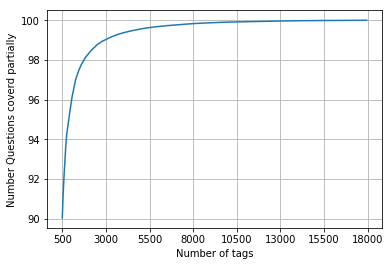

with  5500 tags we are covering  99.033 % of questions


In [45]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [46]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9668 out of  999997


In [47]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35424
number of tags taken : 5500 ( 15.526196928635953 %)


### 4.5 Modeling with less data points (0.5M data points) and more weight to title and 500 tags only.

In [48]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


In [49]:
# http://www.sqlitetutorial.net/sqlite-delete/


read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 400000
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        # for selecting first 0.5M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 500001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 500001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")

Tables in the databse:
QuestionsProcessed
Cleared All the rows


#### 4.5.1 Preprocessing of questions 
1.  Separate Code from Body
2.  Remove Spcial characters from Question title and description (not in code)
3.  Give more weightage to title : Add title three times to the question
4.  Remove stop words (Except 'C')
5.  Remove HTML Tags
6.  Convert all the characters into small letters
7.  Use SnowballStemmer to stem the words

In [50]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0
for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1239
Avg. length of questions(Title+Body) after processing: 424
Percent of questions containing code: 57
Time taken to run this cell : 0:52:38.363657


In [51]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

#### Sample quesitons after preprocessing of data

In [52]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('dynam datagrid bind silverlight dynam datagrid bind silverlight dynam datagrid bind silverlight bind datagrid dynam code wrote code debug code block seem bind correct grid come column form come grid column although necessari bind nthank repli advance..',)
----------------------------------------------------------------------------------------------------
('java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid follow guid link instal jstl got follow error tri launch jsp page java.lang.noclassdeffounderror javax servlet jsp tagext taglibraryvalid taglib declar instal jstl 1.1 tomcat webapp tri project work also tri version 1.2 jstl still messag caus solv',)
----------------------------------------------------------------------------------------------------
('java.sql.sqlexcept microsoft odbc driver

####  Saving Preprocessed data to a Database

In [20]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [4]:
preprocessed_data.head()

,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [6]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])
print("number of rows and columns :", preprocessed_data.shape)

number of data points in sample : 500000
number of dimensions : 2
number of rows and columns : (500000, 2)


#### Converting string Tags to multilable output variables

In [21]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [22]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [23]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

#### Selecting 500 Tags

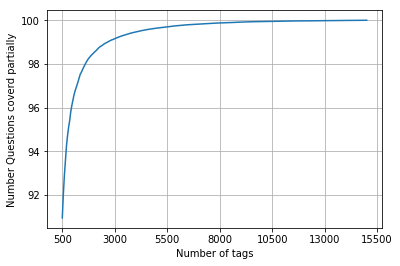

with  5500 tags we are covering  99.157 % of questions
with  500 tags we are covering  90.956 % of questions


In [8]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [9]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 45221 out of  500000


In [24]:
train_datasize = 400000

In [25]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [26]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [27]:
X_train = x_train[0:100001]
Y_train = y_train[0:100001]
X_test = x_test[0:20000]
Y_test = y_test[0:20000]

### Featurizing data with BoW vectorizer

In [28]:
start = datetime.now()
vectorizer = CountVectorizer(max_features=100000,ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(X_train['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:45.393560


In [29]:
x_test_multilabel = vectorizer.transform(X_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:53.206180


In [30]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",Y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",Y_test.shape)

Dimensions of train data X: (100001, 100000) Y : (100001, 500)
Dimensions of test data X: (20000, 100000) Y: (20000, 500)


#### Applying SGD Classifier with log loss with OneVsRest Classifier

In [17]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
classifier.fit(x_train_multilabel, Y_train)
predictions = classifier.predict (x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:05:16.046104


In [18]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import f1_score,precision_score,recall_score
print("Accuracy    :",metrics.accuracy_score(Y_test, predictions))
print("Hamming loss : ",metrics.hamming_loss(Y_test,predictions))

print("Performance metric: micro average")
print("precision    :",precision_score(Y_test, predictions, average='micro'))
print("recall       :",recall_score(Y_test, predictions, average='micro'))
print("f1_score     :",f1_score(Y_test, predictions, average='micro'))
print('\n')

print("Performance metric: macro average")
print("precision    :",precision_score(Y_test, predictions, average='macro'))
print("recall       :",recall_score(Y_test, predictions, average='macro'))
print("f1           :",f1_score(Y_test, predictions, average='macro'))


Accuracy    : 0.08985
Hamming loss :  0.0074504
Performance metric: micro average
precision    : 0.23176348035856245
recall       : 0.4781416129397127
f1_score     : 0.3121988146452244


Performance metric: macro average
precision    : 0.1685551428554379
recall       : 0.3926411821799092
f1           : 0.22555158951508114


### Applying Logistic Regression with OneVsRest Classifier

In [19]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'))
classifier_2.fit(x_train_multilabel, Y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:48:55.181777


In [20]:
print("Accuracy    :",metrics.accuracy_score(Y_test, predictions_2))
print("Hamming loss : ",metrics.hamming_loss(Y_test,predictions_2))

print("Performance metric: micro average")
print("precision    :",precision_score(Y_test, predictions_2, average='micro'))
print("recall       :",recall_score(Y_test, predictions_2, average='micro'))
print("f1_score     :",f1_score(Y_test, predictions_2, average='micro'))
print('\n')


print("Performance metric: macro average")
print("precision    :",precision_score(Y_test, predictions_2, average='macro'))
print("recall       :",recall_score(Y_test, predictions_2, average='macro'))
print("f1           :",f1_score(Y_test, predictions_2, average='macro'))
 


#print (metrics.classification_report(Y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)


Accuracy    : 0.20495
Hamming loss :  0.0031549
Performance metric: micro average
precision    : 0.5788320866223086
recall       : 0.39605248275082006
f1_score     : 0.4703077517167274


Performance metric: macro average
precision    : 0.43798237663621703
recall       : 0.3172976077573141
f1           : 0.358540066691543
Time taken to run this cell : 0:49:34.036788


In [21]:
classifier_2.estimator

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Applying  gridSearchCV with Logistic Regression

In [31]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

start = datetime.now()
model = OneVsRestClassifier(LogisticRegression(penalty='l1'))
alphas = [0.0001,0.001,0.01,0.1,1]
p_grid_NB = {'estimator__C': alphas}
gsearc = GridSearchCV(estimator=model, cv=3,scoring = 'f1_micro',  verbose=5,param_grid=p_grid_NB)
gsearch = gsearc.fit(x_train_multilabel, Y_train)
print("Time taken to run this cell :", datetime.now() - start)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] estimator__C=0.0001 .............................................
[CV] . estimator__C=0.0001, score=0.0008023235289398097, total= 5.7min
[CV] estimator__C=0.0001 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.9min remaining:    0.0s


[CV] . estimator__C=0.0001, score=0.0012425406686830704, total= 6.0min
[CV] estimator__C=0.0001 .............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.0min remaining:    0.0s


[CV] ................... estimator__C=0.0001, score=0.0, total= 3.3min
[CV] estimator__C=0.001 ..............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 15.4min remaining:    0.0s


[CV] .... estimator__C=0.001, score=0.07891206244663984, total= 6.0min
[CV] estimator__C=0.001 ..............................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 21.5min remaining:    0.0s


[CV] .... estimator__C=0.001, score=0.26282330401463033, total= 4.5min
[CV] estimator__C=0.01 ...............................................
[CV] ..... estimator__C=0.01, score=0.27146244235428985, total= 7.1min
[CV] estimator__C=0.01 ...............................................
[CV] ..... estimator__C=0.01, score=0.32935676080852744, total= 6.7min
[CV] estimator__C=0.01 ...............................................
[CV] ...... estimator__C=0.01, score=0.3807046264941356, total= 6.2min
[CV] estimator__C=0.1 ................................................
[CV] ....... estimator__C=0.1, score=0.3828407789232532, total= 9.9min
[CV] estimator__C=0.1 ................................................
[CV] ...... estimator__C=0.1, score=0.43130965155023443, total=16.4min
[CV] estimator__C=0.1 ................................................
[CV] ...... estimator__C=0.1, score=0.46311364116386894, total= 9.4min
[CV] estimator__C=1 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 152.9min finished


Time taken to run this cell : 3:13:39.038352


No handles with labels found to put in legend.



best estimator is  OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

best train accuracy score is 0.4553605796293593

 train accuracy scores for each alpha values  [0.00068163 0.17315914 0.32717407 0.42575432 0.45536058]

 graph between train accuracy mean scores for each alpha values


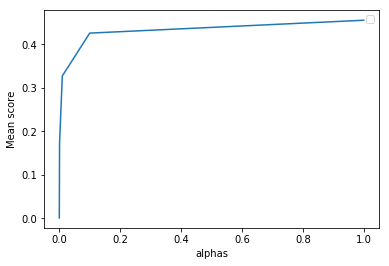

In [32]:
print("\nbest estimator is ",gsearch.best_estimator_)
print("\nbest train accuracy score is",gsearch.best_score_)
scores = [x[1] for x in gsearch.grid_scores_]
scores = np.array(scores).reshape(len(alphas))
print("\n train accuracy scores for each alpha values ",scores)
print("\n graph between train accuracy mean scores for each alpha values")
plt.plot(alphas, scores)
plt.legend()
plt.xlabel('alphas')
plt.ylabel('Mean score')
plt.show()

In [33]:
gsearc.best_estimator_

OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1)

In [34]:
gsearch.best_score_

0.4553605796293593

In [35]:
predictions_3 = gsearch.predict(x_test_multilabel)
print("Accuracy    :",metrics.accuracy_score(Y_test, predictions_3))
print("Hamming loss : ",metrics.hamming_loss(Y_test,predictions_3))

print("Performance metric: micro average")
print("precision    :",precision_score(Y_test, predictions_3, average='micro'))
print("recall       :",recall_score(Y_test, predictions_3, average='micro'))
print("f1_score     :",f1_score(Y_test, predictions_3, average='micro'))
print('\n')


print("Performance metric: macro average")
print("precision    :",precision_score(Y_test, predictions_3, average='macro'))
print("recall       :",recall_score(Y_test, predictions_3, average='macro'))
print("f1           :",f1_score(Y_test, predictions_3, average='macro'))
 


#print (metrics.classification_report(Y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)


Accuracy    : 0.20485
Hamming loss :  0.0031541
Performance metric: micro average
precision    : 0.5789908673912145
recall       : 0.3961938694717792
f1_score     : 0.47045984923526346


Performance metric: macro average
precision    : 0.4381436622046259
recall       : 0.3174107713036249
f1           : 0.3586698995288429
Time taken to run this cell : 3:21:34.719888


### Applying SGD classifier with OneVsRest Classifier with Hinge loss i.e Linear SVM

In [36]:
start = datetime.now()
classifier3 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.00001, penalty='l1'))
classifier3.fit(x_train_multilabel, Y_train)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:50.586006


In [37]:
predictions_4 = classifier3.predict(x_test_multilabel)

print("Accuracy    :",metrics.accuracy_score(Y_test, predictions_4))
print("Hamming loss : ",metrics.hamming_loss(Y_test,predictions_4))

print("Performance metric: micro average")
print("precision    :",precision_score(Y_test, predictions_4, average='micro'))
print("recall       :",recall_score(Y_test, predictions_4, average='micro'))
print("f1_score     :",f1_score(Y_test, predictions_4, average='micro'))
print('\n')


print("Performance metric: macro average")
print("precision    :",precision_score(Y_test, predictions_4, average='macro'))
print("recall       :",recall_score(Y_test, predictions_4, average='macro'))
print("f1           :",f1_score(Y_test, predictions_4, average='macro'))
 


#print (metrics.classification_report(Y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy    : 0.08875
Hamming loss :  0.0073805
Performance metric: micro average
precision    : 0.23267361159404165
recall       : 0.4730516909851827
f1_score     : 0.3119248948845362


Performance metric: macro average
precision    : 0.16458530869236734
recall       : 0.3866113442293175
f1           : 0.22060162061191144
Time taken to run this cell : 0:05:15.039016


In [39]:
!pip3 install PrettyTable

  Running setup.py bdist_wheel for PrettyTable ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
Successfully built PrettyTable
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model","vectorizer","Hyperparameter", "precision_micro", "recall_micro","f1_score_micro","accuracy" ]

x.add_row(["SGD classifier(log loss)","BOW",0.00001, 0.2317, 0.4781,0.3121,0.08954])
x.add_row(["LogisticRegression","BOW",0.00001,0.5788, 0.3960,0.4703,0.2049])
x.add_row(["LogisticRegression(grid search)","BOW",1, 0.5789, 0.3960,0.4704,0.2048])
x.add_row(["Linear SVM ","BOW",0.00001,0.2326, 0.4736, 0.3101,0.089])
print(x)

+---------------------------------+------------+----------------+-----------------+--------------+----------------+----------+
|              Model              | vectorizer | Hyperparameter | precision_micro | recall_micro | f1_score_micro | accuracy |
+---------------------------------+------------+----------------+-----------------+--------------+----------------+----------+
|     SGD classifier(log loss)    |    BOW     |     1e-05      |      0.229      |    0.4761    |     0.3092     |  0.0874  |
|        LogisticRegression       |    BOW     |     1e-05      |      0.5789     |    0.396     |     0.4703     |  0.2049  |
| LogisticRegression(grid search) |    BOW     |       1        |      0.5791     |    0.396     |     0.4704     |  0.2048  |
|           Linear SVM            |    BOW     |     1e-05      |      0.2306     |    0.4736    |     0.3101     |  0.089   |
+---------------------------------+------------+----------------+-----------------+--------------+-------------

### from the above table it is clearly shown that we got the best f1_micro with linear SVM as 0.31.

### 1. Business Problem : Question Tag predictor.
1. The Main Objective of this problem is to find the Tag i.e Java, Javascript, python etc.. for a given text of question posted
   on Stack Overflow by the end customer.
    
### 2. About the Data
1. We have labeled data with 4 columns as Id,Title,Body,Tags. 
   and we have total number of rows as 6034195
2. Here Tags variable is target variable multi label, so here we are solving  a multi-label classification problem.

### 3. Steps involved in solving the problem.

#### 1. (Step 1) Exploratory Data Analysis 
1. In this step we do the basic data staticstics to know how the data is available.

2. We find how much percentage of duplicated and non duplicated data is present in our dataset. we found as below.
   number of duplicate questions : 1827881 ( 30.2920389063 % )
   

3. Finding number of Unique questions
   Total number of  Unique Questions are: 4206314 
   Number of unique tags : 42048
   
4. There are total 153 tags which are used more than 10000 times.
   14 tags are used more than 100000 times.
   Most frequent tag (i.e. c#) is used 331505 times.
   Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.
                      

5. A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

6. Majority of the most frequent tags are programming language.


#### 3. (Step 2) Data Preprocessing.
1. In this step we clean the data if there are any kind of unwanted words, symbols etc.. is present.

2. Removing html tags, we defined our own function with html symbols and tags to remove from the data.
   Removing Punctuations, we defined own function to remove punctuationa and exclamatory marks.
   Performing stemming , here we used predefined module Porter Stemmer to stem the words.
   Removing Stopwords, we used inbuilt stopwords(english) module to remove the stopwords present except some words
                      
#### 2. (Step 3) Basic Feature Extraction.
1. We consider top 15% tags which covers 99% of the questions, this we got by doing exploratory analysys on  Tags vs questions.

#### 5. (Step 5) Converting our Text data to vectors.
1. In this step we had featurize the question column(variable) using tfidfvectorizer of 200000 features.
   
2. After the spliting and data randomly as 80:20 and conversion of dependent and independent variable we got the featurization as follows.
   Diamensions of train data X: (799999, 88244) Y : (799999, 5500)
   Diamensions of test data X: (200000, 88244) Y: (200000, 5500)


#### 6. (Step 6) Model Building using Machine Learning Algorithms
1. Since we have Large Dimensions of data , we are going to choose Logistic Regression algorithm because it perfoms well with      large dimensions because of its Linearity(linear model) and Time complexity compared to other models.

2. Here I took 1L data points according to my PC configuration as suggested and started building the models.

3. Applying SGD Classifier with log loss with OneVsRest Classifier(multi lable) and performance metric f1_mirco and f1_macro.
   we got f1_micro=0.3121 and f1_macro =0.2255 

3. Applying Logistic Regression with OneVsRest Classifier(multi lable) and performance metric f1_mirco and f1_macro.
   we got f1_micro=0.4703 and f1_macro = 0.3585 
   
4. Applied gridSearchCV with Logistic Regression with different values of alpha as 0.0001,0.001,0.01,0.1,1
   we got f1_micro= 0.4704 and f1_macro = 0.3586
   
5. Applied SGD classifier with OneVsRest Classifier with Hinge loss i.e Linear SVM.
   we got f1_micro= 0.3119 and f1_macro =  0.2206

6. Final Result is Tabulated using the PrettyTable.



